Note that the performance metrics below might change as the current date changed

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import requests
import yfinance as yf
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier

import seaborn as sns

### Data Collection

In [5]:
coin = "BTC"
# funding rate
fr_url = "https://fapi.binance.com/fapi/v1/fundingRate"
# open interest
oi_url = "https://fapi.binance.com/futures/data/openInterestHist"
# long/short ratio (account)
ra_url = "https://fapi.binance.com/futures/data/topLongShortAccountRatio"
# long/short ratio (positions)
rp_url = "https://fapi.binance.com/futures/data/topLongShortPositionRatio"
# long/short ratio (global)
rg_url = "https://fapi.binance.com/futures/data/globalLongShortAccountRatio"
# taker buy/sell volume ratio
tv_url = "https://fapi.binance.com/futures/data/takerlongshortRatio"


In [6]:
end_datetime = pd.to_datetime(datetime.today().date())

In [7]:
# fr_dfs = []
oi_dfs = []
ra_dfs = []
rp_dfs = []
rg_dfs = []
tv_dfs = []
px_dfs = []

# Binance futures only provide data for the last 30 days
start_datetime = end_datetime - timedelta(days=29)

while start_datetime < end_datetime:

    oi_params = {
        "symbol": f"{coin}USDT",
        "period": "5m",
        "limit": 500,
        "startTime": int(start_datetime.timestamp() * 1000),
        "endTime": int((start_datetime + timedelta(days=1)).timestamp() * 1000 - 1)
    }

    ra_params = {
        "symbol": f"{coin}USDT",
        "period": "5m",
        "limit": 500,
        "startTime": int(start_datetime.timestamp() * 1000),
        "endTime": int((start_datetime + timedelta(days=1)).timestamp() * 1000 - 1)
    }

    rp_params = {
        "symbol": f"{coin}USDT",
        "period": "5m",
        "limit": 500,
        "startTime": int(start_datetime.timestamp() * 1000),
        "endTime": int((start_datetime + timedelta(days=1)).timestamp() * 1000 - 1)
    }

    rg_params = {
        "symbol": f"{coin}USDT",
        "period": "5m",
        "limit": 500,
        "startTime": int(start_datetime.timestamp() * 1000),
        "endTime": int((start_datetime + timedelta(days=1)).timestamp() * 1000 - 1)
    }

    tv_params = {
        "symbol": f"{coin}USDT",
        "period": "5m",
        "limit": 500,
        "startTime": int(start_datetime.timestamp() * 1000),
        "endTime": int((start_datetime + timedelta(days=1)).timestamp() * 1000) - 1
    }

    oi_response = pd.DataFrame(
        requests.get(oi_url, params=oi_params).json())
    ra_response = pd.DataFrame(
        requests.get(ra_url, params=ra_params).json())
    rp_response = pd.DataFrame(
        requests.get(rp_url, params=rp_params).json())
    rg_response = pd.DataFrame(
        requests.get(rg_url, params=rg_params).json())
    tv_response = pd.DataFrame(
        requests.get(tv_url, params=tv_params).json())

    curr_oi_df = oi_response[["timestamp",
                              "sumOpenInterest"]].set_index("timestamp")
    curr_ra_df = ra_response[["timestamp", "longShortRatio"]].rename(
        columns={"longShortRatio": "topTraderAccountsLongShortRatio"}).set_index("timestamp")
    curr_rp_df = rp_response[["timestamp", "longShortRatio"]].rename(
        columns={"longShortRatio": "topTraderPositionsLongShortRatio"}).set_index("timestamp")
    curr_rg_df = rg_response[["timestamp", "longShortRatio"]].rename(
        columns={"longShortRatio": "globalAccountsLongShortRatio"}).set_index("timestamp")
    curr_tv_df = tv_response[["timestamp", "buySellRatio"]].rename(
        columns={"buySellRatio": "buySellRatio"}).set_index("timestamp")

    curr_px_df = yf.download(f"{coin}-USD", interval="5m", start=start_datetime,
                                end=(start_datetime + timedelta(days=1)))
    curr_px_df = curr_px_df[["Open"]].rename(columns={"Open": "price"})
    curr_px_df.index = curr_px_df.index.astype(np.int64) // 10**6

    oi_dfs.append(curr_oi_df)
    ra_dfs.append(curr_ra_df)
    rp_dfs.append(curr_rp_df)
    rg_dfs.append(curr_rg_df)
    tv_dfs.append(curr_tv_df)
    px_dfs.append(curr_px_df)

    start_datetime = start_datetime + timedelta(days=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
oi_df = pd.concat(oi_dfs)
ra_df = pd.concat(ra_dfs)
rp_df = pd.concat(rp_dfs)
rg_df = pd.concat(rg_dfs)
tv_df = pd.concat(tv_dfs)
px_df = pd.concat(px_dfs)


In [9]:
df = pd.concat([oi_df, ra_df, rp_df, rg_df, tv_df, px_df], axis=1).sort_index()
df.index = pd.to_datetime(df.index, unit="ms")
df = df.reindex(pd.date_range(start=end_datetime - timedelta(days=29),
                end=end_datetime, freq="5min")).astype(float)


### Feature Enginering


In [10]:
df["sumOpenInterestChange"] = df["sumOpenInterest"].pct_change()
df["logBuySellRatio"] = np.log(df["buySellRatio"])
df["logTopTraderAccountsLongShortRatio"] = np.log(
    df["topTraderAccountsLongShortRatio"]
)
df["logTopTraderPositionsLongShortRatio"] = np.log(
    df["topTraderPositionsLongShortRatio"]
)
df["logGlobalAccountsLongShortRatio"] = np.log(
    df["globalAccountsLongShortRatio"]
)
df["pastPxChange"] = df["price"].pct_change().shift(-1)
df["futurePxChange"] = df["price"].pct_change().shift(-2)


In [11]:
df

,sumOpenInterest,topTraderAccountsLongShortRatio,topTraderPositionsLongShortRatio,globalAccountsLongShortRatio,buySellRatio,price,sumOpenInterestChange,logBuySellRatio,logTopTraderAccountsLongShortRatio,logTopTraderPositionsLongShortRatio,logGlobalAccountsLongShortRatio,pastPxChange,futurePxChange
2022-07-25 00:00:00,115594.951,1.0631,1.1874,1.0479,1.0905,NaN,NaN,0.086636,0.061189,0.171766,0.046788,NaN,NaN
2022-07-25 00:05:00,115687.782,1.0683,1.1889,1.0534,1.6769,NaN,0.000803,0.516947,0.066069,0.173029,0.052023,NaN,NaN
2022-07-25 00:10:00,115444.056,1.0640,1.1915,1.0525,1.9589,NaN,-0.002107,0.672383,0.062035,0.175213,0.051168,NaN,NaN
2022-07-25 00:15:00,115425.996,1.0683,1.1910,1.0602,0.6979,NaN,-0.000156,-0.359679,0.066069,0.174793,0.058458,NaN,NaN
2022-07-25 00:20:00,115674.061,1.0713,1.1895,1.0631,0.6206,NaN,0.002149,-0.477069,0.068873,0.173533,0.061189,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-22 23:40:00,109224.798,2.0760,1.0640,2.2165,1.3368,21246.404297,-0.000196,0.290279,0.730443,0.062035,0.795929,0.001652,0.002758
2022-08-22 23:45:00,108932.811,2.0713,1.0623,2.2331,1.4473,21281.500000,-0.002673,0.369700,0.728176,0.060436,0.803391,0.002758,0.001462
2022-08-22 23:50:00,108381.228,2.0516,1.0622,2.2216,1.7905,21340.191406,-0.005064,0.582495,0.718620,0.060342,0.798228,0.001462,0.001387
2022-08-22 23:55:00,108579.289,2.0266,1.0635,2.1928,NaN,21371.394531,0.001827,NaN,0.706360,0.061565,0.785179,0.001387,NaN


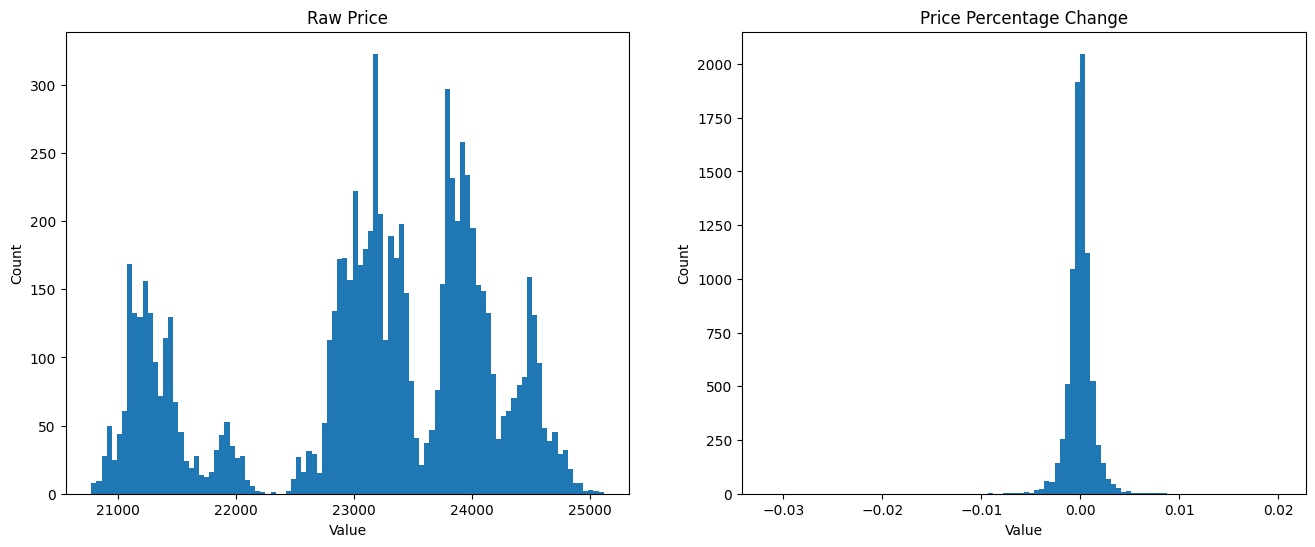

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.hist(df["price"], bins=100)
ax1.set_xlabel("Value")
ax1.set_ylabel("Count")
ax1.set_title("Raw Price")
ax2.hist(df["price"].pct_change(), bins=100)
ax2.set_xlabel("Value")
ax2.set_ylabel("Count")
ax2.set_title("Price Percentage Change")
plt.show()

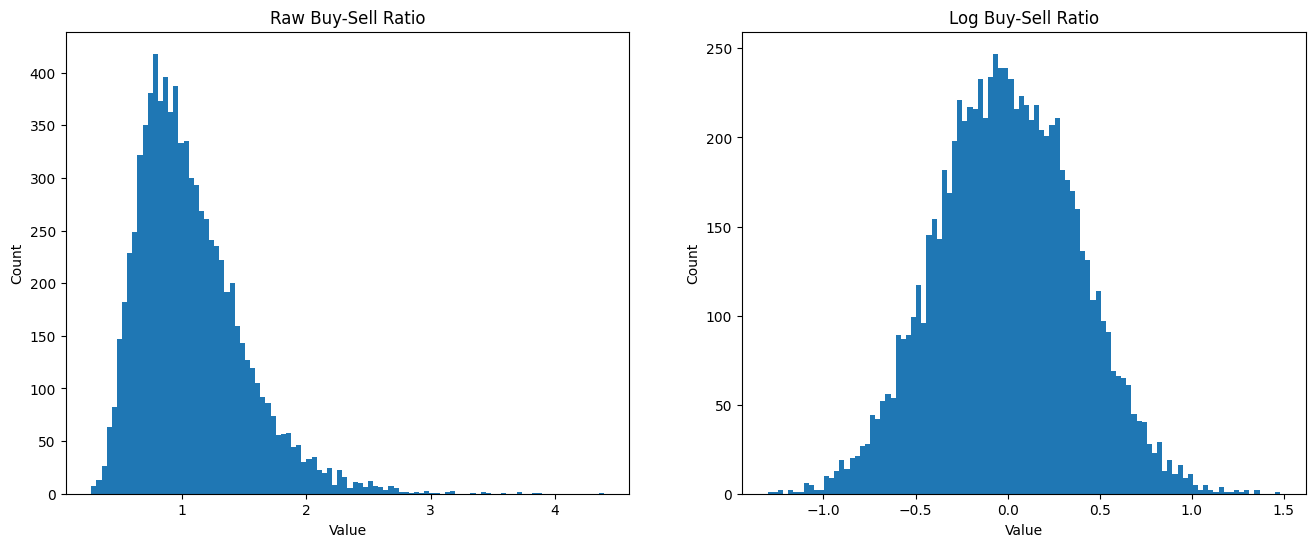

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.hist(df["buySellRatio"], bins=100)
ax1.set_xlabel("Value")
ax1.set_ylabel("Count")
ax1.set_title("Raw Buy-Sell Ratio")
ax2.hist(df["logBuySellRatio"], bins=100)
ax2.set_xlabel("Value")
ax2.set_ylabel("Count")
ax2.set_title("Log Buy-Sell Ratio")
plt.show()


In [14]:
df = df.drop(columns=[
                "sumOpenInterest",
                "price",
                "buySellRatio",
                "topTraderAccountsLongShortRatio",
                "topTraderPositionsLongShortRatio",
                "globalAccountsLongShortRatio",
            ])
data_df = df.dropna()


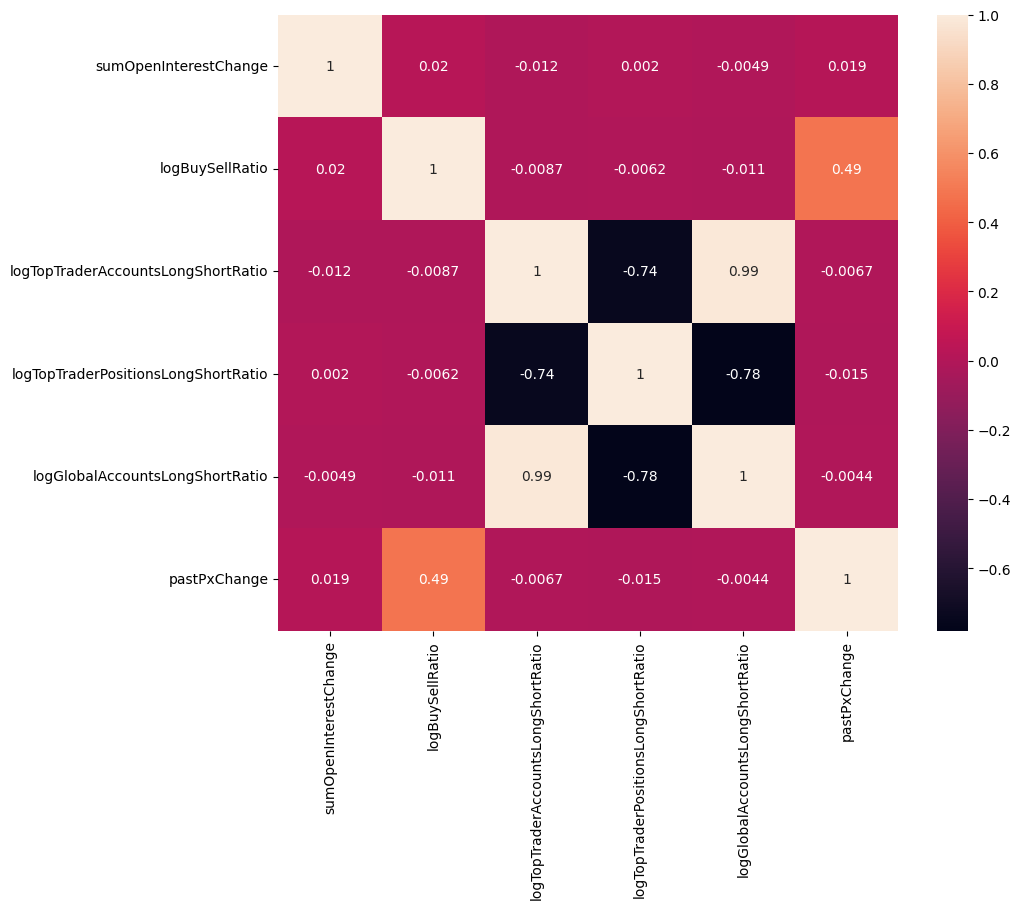

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_df[data_df.columns[:-1]].corr(), annot=True)
plt.show()

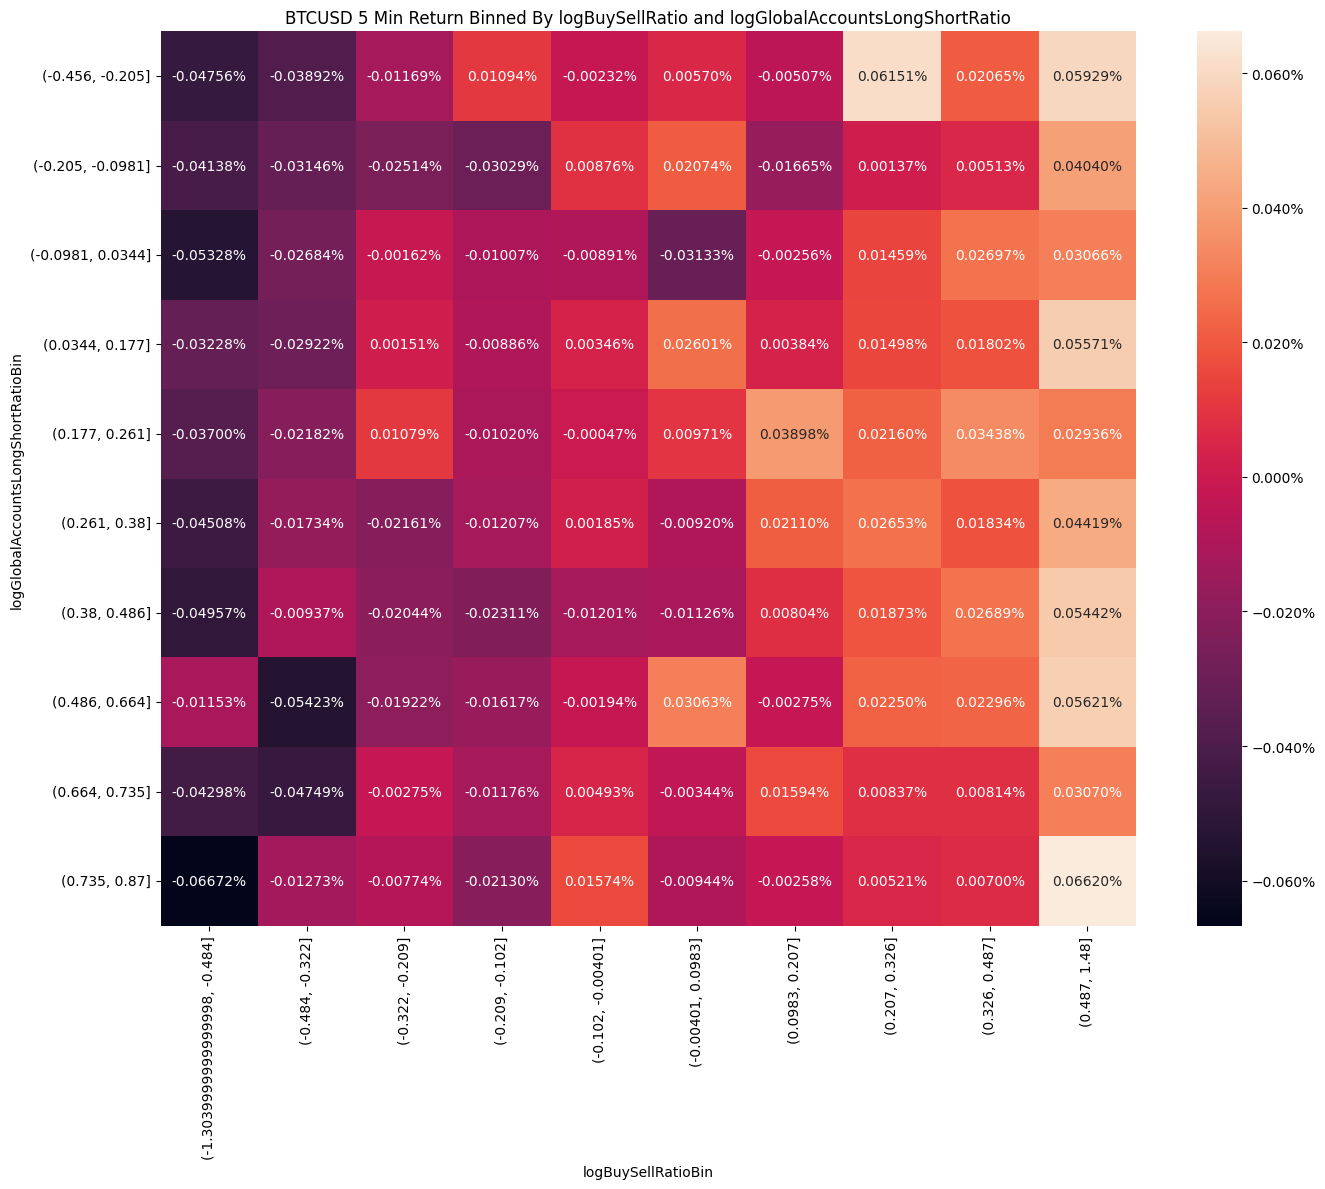

In [16]:
cuts = pd.DataFrame(
    {
        str(feature) + "Bin": pd.qcut(data_df[feature], 10)
        for feature in ["logBuySellRatio", "logGlobalAccountsLongShortRatio"]
    }
)
mean_df = (
    data_df.join(cuts)
    .groupby(list(cuts))
    .mean()
    .unstack(level=0)["futurePxChange"]
)

plt.figure(figsize=(14, 12))
sns.heatmap(
    mean_df, annot=True, fmt=".5%", cbar_kws={"format": mtick.PercentFormatter(1)}
)
plt.title(f"BTCUSD 5 Min Return Binned By logBuySellRatio and logGlobalAccountsLongShortRatio")
plt.tight_layout()
plt.show()

In [17]:
data_df

,sumOpenInterestChange,logBuySellRatio,logTopTraderAccountsLongShortRatio,logTopTraderPositionsLongShortRatio,logGlobalAccountsLongShortRatio,pastPxChange,futurePxChange
2022-07-25 04:00:00,0.001561,-0.332401,0.314154,0.157943,0.244435,0.000115,-0.002120
2022-07-25 04:05:00,0.003215,-0.298002,0.315832,0.157773,0.248889,-0.002120,-0.000370
2022-07-25 04:10:00,-0.005431,0.067191,0.323604,0.159479,0.250525,-0.000370,0.001323
2022-07-25 04:15:00,-0.002324,0.018233,0.325628,0.160417,0.250525,0.001323,0.001187
2022-07-25 04:20:00,0.000966,0.535089,0.330957,0.159650,0.256191,0.001187,-0.000508
...,...,...,...,...,...,...,...
2022-08-22 23:30:00,-0.000522,-0.331146,0.731358,0.061471,0.794981,-0.000283,0.001747
2022-08-22 23:35:00,-0.000321,0.572617,0.730443,0.061001,0.793581,0.001747,0.001652
2022-08-22 23:40:00,-0.000196,0.290279,0.730443,0.062035,0.795929,0.001652,0.002758
2022-08-22 23:45:00,-0.002673,0.369700,0.728176,0.060436,0.803391,0.002758,0.001462


In [18]:
def get_model_coefs(data_df, reg):
    dates = np.unique(data_df.index.date)

    train_dates = dates[0:15]
    val_dates = dates[15]

    train_df = data_df[np.isin(data_df.index.date, train_dates)].copy()
    val_df = data_df[np.isin(data_df.index.date, val_dates)].copy()

    col_means = train_df.iloc[:, :-1].mean()
    col_stds = train_df.iloc[:, :-1].std()

    # normalization, necesssary for lasso
    train_df.iloc[:, :-1] = (train_df.iloc[:,:-1].copy() - col_means) / col_stds
    val_df.iloc[:, :-1] = (val_df.iloc[:, :-1].copy() - col_means) / col_stds

    model = smf.ols(formula="futurePxChange ~ sumOpenInterestChange + logBuySellRatio + logTopTraderAccountsLongShortRatio + logTopTraderPositionsLongShortRatio + logGlobalAccountsLongShortRatio + pastPxChange - 1", data=train_df)
    model = model.fit_regularized(alpha=reg, L1_wt=1, refit=False)
    
    return model.params


In [19]:
regs = [0, 1e-7, 2e-7, 5e-7, 1e-6, 2e-6, 5e-6,
        1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3]

result = pd.DataFrame({reg: get_model_coefs(data_df, reg) for reg in regs})

In [20]:
result.T

,sumOpenInterestChange,logBuySellRatio,logTopTraderAccountsLongShortRatio,logTopTraderPositionsLongShortRatio,logGlobalAccountsLongShortRatio,pastPxChange
0.000000e+00,0.000040,0.000167,0.000135,-0.000085,-0.000189,0.000120
1.000000e-07,0.000040,0.000167,0.000130,-0.000085,-0.000182,0.000120
2.000000e-07,0.000040,0.000167,0.000124,-0.000084,-0.000176,0.000120
5.000000e-07,0.000040,0.000167,0.000108,-0.000081,-0.000158,0.000120
1.000000e-06,0.000039,0.000167,0.000081,-0.000077,-0.000128,0.000120
2.000000e-06,0.000038,0.000167,0.000026,-0.000069,-0.000067,0.000119
5.000000e-06,0.000035,0.000166,0.000000,-0.000056,-0.000030,0.000117
1.000000e-05,0.000031,0.000162,0.000000,-0.000039,-0.000013,0.000114
2.000000e-05,0.000021,0.000156,0.000000,-0.000021,0.000000,0.000108
5.000000e-05,0.000000,0.000136,0.000000,0.000000,0.000000,0.000088


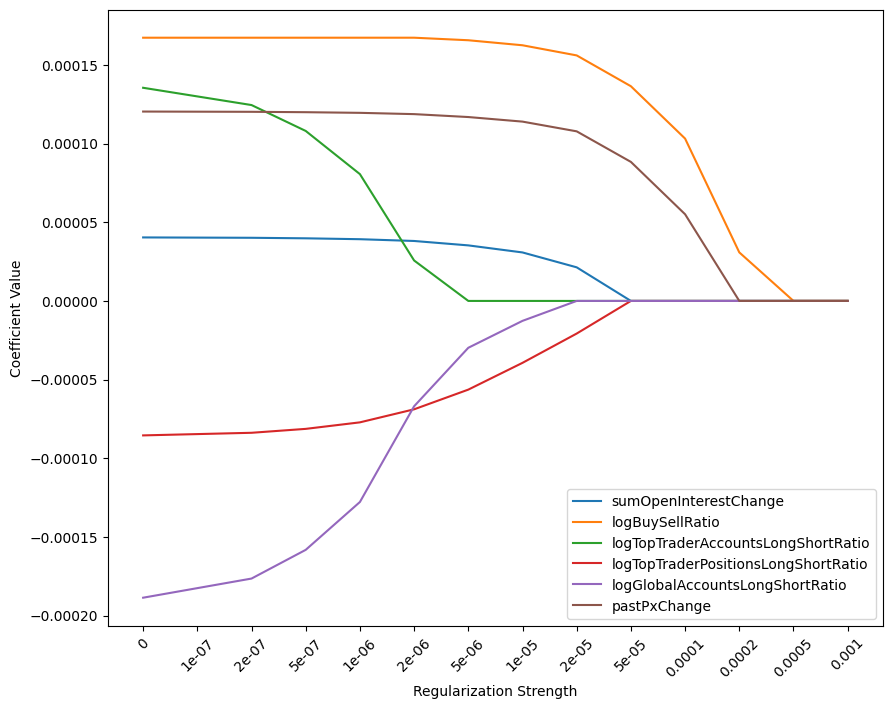

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(range(0, len(regs)), result.T)
plt.xticks(range(0, len(regs)), labels=regs, rotation=45)
plt.xlabel("Regularization Strength")
plt.ylabel("Coefficient Value")
plt.legend(result.T.columns)
plt.show()

In [22]:
def get_rolling_r2(data_df, reg):
    
    dates = np.unique(data_df.index.date)
    
    insampler2 = []
    rollingr2 = []

    for i in range(15, len(dates)):
        
        train_dates = dates[i-15:i]
        val_dates = dates[i]

        train_df = data_df[np.isin(data_df.index.date, train_dates)].copy()
        val_df = data_df[np.isin(data_df.index.date, val_dates)].copy()
        
        col_means = train_df.mean()
        col_stds = train_df.std()
        
        # normalization, necesssary for lasso
        train_df = (train_df - col_means) / col_stds
        val_df = (val_df - col_means) / col_stds

        model = smf.ols(formula="futurePxChange ~ sumOpenInterestChange + logBuySellRatio + logTopTraderAccountsLongShortRatio + logTopTraderPositionsLongShortRatio + logGlobalAccountsLongShortRatio + pastPxChange - 1", data=train_df)
        model = model.fit_regularized(alpha=reg, L1_wt=1, refit=True)
        y_pred = model.predict(val_df)

        insampler2.append(model.rsquared)
        rollingr2.append(1 - np.power(val_df["futurePxChange"] - y_pred, 2).sum() /  (np.power(val_df["futurePxChange"], 2).sum()))
    
    return pd.DataFrame(data=np.array([insampler2, rollingr2]).T, index=dates[15:], columns=["insample", "outOfSample"])

In [23]:
result = get_rolling_r2(data_df, reg=1e-5)

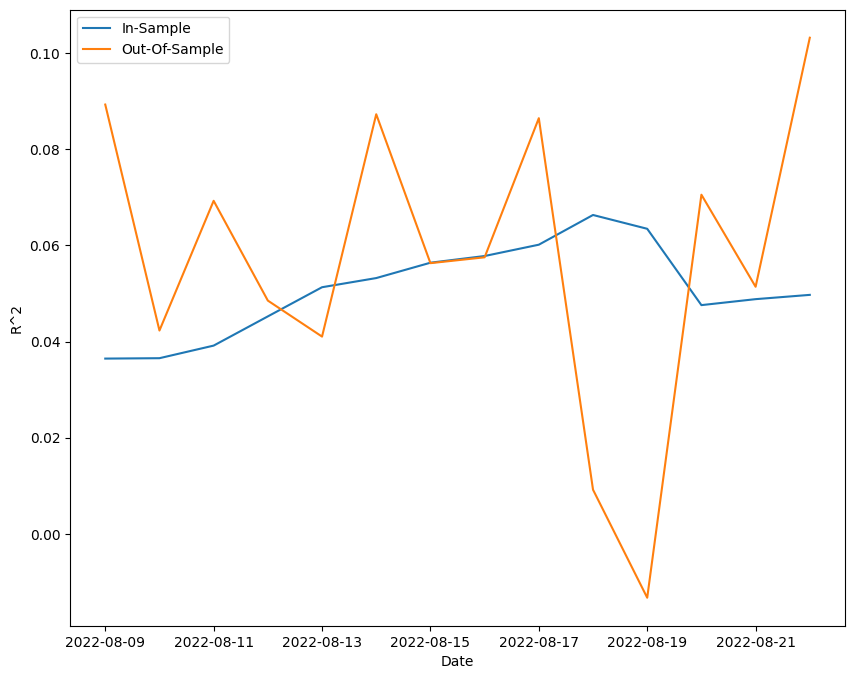

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(result["insample"], label="In-Sample")
plt.plot(result["outOfSample"], label="Out-Of-Sample")
plt.ylabel("R^2")
plt.xlabel("Date")
plt.legend()
plt.show()

### Decision Tree and XGBoost

In [26]:
data_df.loc[data_df["futurePxChange"] <= 0, 'futurePxDirection'] = 0
data_df.loc[data_df["futurePxChange"] >= 0,'futurePxDirection'] = 1

/var/folders/h1/tr1q_6210b3fh7z5w19c2qvm0000gp/T/ipykernel_18223/2358434186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[data_df["futurePxChange"] <= 0, 'futurePxDirection'] = 0


In [27]:
feature_cols = ['sumOpenInterestChange', 'logBuySellRatio', 'logTopTraderAccountsLongShortRatio', 'logTopTraderPositionsLongShortRatio', 'logGlobalAccountsLongShortRatio', 'pastPxChange']
x = data_df[feature_cols]
y = data_df['futurePxDirection']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

dtc = DecisionTreeClassifier()
dtc = dtc.fit(x_train,y_train)
y_pred_dtc = dtc.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dtc))

Accuracy: 0.5265060240963856


In [28]:
xgb = XGBClassifier()
xgb = xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_xgb))

Accuracy: 0.5355421686746988
